# Regression in PySpark's MLlib

PySpark offers 7 algorithms for regression which we will review in this lecture. The content of this notebook will be very similar to what we did in the classification lectures where we will see how to prep our data first, and then go over how to train and evaluate each model individually. 

**Recap from the Regression lecture**<br>
Remember that regression problems require that the **dependent variable** in your dataset be continuous (like age or height) and not categorical like (young vs old, or fat vs skinny). Regression analysis tries to find the relationship between this variable (the dependent) and each of the independent variables which can be either continous or categorical. As with any machine learning problem, the basic question of regression analysis is "what factors affect our outcome."

For example, some research questions that might be solved using regression anlaysis might be:

What factors effect...

1. inflation rate and how we predict it longer term?
2. price increases upon demand
3. the height or weight of a person
4. crop yield of vegetation like corn or apple trees
5. income of a person


## Available Algorithms
These are the regression algorithms Spark offers:

1. Linear regression 
     - most simplistic and easy to understand
2. Generalized linear regression (out of scope)
3. Decision tree regression 
     - most basic of the tree algorithms)
4. Random forest regression 
     - a bit more complex than decision tree as it is an ensemble method as it combines several models in order to produce one really great predictive model
5. Gradient-boosted tree regression 
     - most complex of the tree algorithms as it takes a more hierarchical approach to learning making it more efficient
6. Survival regression (Out of scope)
7. Isotonic regression (Out of scope)

In [1]:
# First let's create our PySpark instance
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("Regression").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [2]:
# Read in dependencies

# For data prep
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer

# To check for multicolinearity
from pyspark.ml.stat import Correlation

# For training and evaluation
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Import Dataset

This is a dataset containing housing pricing data for California. Each row of data represents the median statistics for a block (eg. median income, median age of house, etc.). You could this data in a number of ways, but we will use it to predict the median house value. 


### About this dataset 

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

**Source:** https://www.kaggle.com/camnugent/california-housing-prices

In [4]:
path =""
df = spark.read.csv(path+'housing.csv',inferSchema=True,header=True)

**View data**

In [5]:
df.limit(6).toPandas()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY


**And of course the schema :)**

In [6]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [7]:
# Starting
print(df.count())
print(len(df.columns))

20640
10


**Drop any missing values**

Let's go ahead and drop any missing values for the sake of simplicity for this lecture as we have already covered the alternatives in subsequent lectures. 

In [9]:
#drop missing data
df = df.na.drop()
df.count()

20433

## Format Data 

MLlib requires all input columns of your dataframe to be vectorized. You will see that we rename our dependent var to label as that is what is expected for all MLlib applications. If we rename once here, we won't need to specify it later on!

In [10]:
input_columns = ['total_bedrooms','population','households','median_income']
dependent_var = 'median_house_value'

In [11]:
renamed = df.withColumnRenamed(dependent_var,'label')

# Make sure dependent variable is numeric and change if it's not
if str(renamed.schema['label'].dataType) != 'IntegerType':
    renamed = renamed.withColumn("label", renamed["label"].cast(FloatType()))

In [12]:
# Convert all string type data in the input column list to numeric
# Otherwise the Algorithm will not be able to process it

# First create empty lists set up to divide you input list into numeric and string data types
numeric_inputs = []
string_inputs = []
for column in input_columns:
    if str(renamed.schema[column].dataType) == 'StringType':
        new_col_name = column+"_num"
        string_inputs.append(new_col_name)
    else:
        numeric_inputs.append(column)
        indexed = renamed
        
# If the dataframe contains string types
if len(string_inputs) != 0: 
    # Then use the string indexer to convert them to numeric
    # Be careful not to convert a continuous variable that was read in incorrectly here
    # This is meant for categorical columns only
    for column in input_columns:
        if str(renamed.schema[column].dataType) == 'StringType':
            indexer = StringIndexer(inputCol=column, outputCol=column+"_num") 
            indexed = indexer.fit(renamed).transform(renamed)
else:
    indexed = renamed

### Treat outliers

This is same approach as we discussed in the classification lecture. It is optional but may improve your model performance so it's considered best practice. 

In [13]:
# Create empty dictionary d
d = {}
# Create a dictionary of percentiles you want to set
# We do top and bottom 1 % which is pretty common
for col in numeric_inputs: 
    d[col] = indexed.approxQuantile(col,[0.01,0.99],0.25) #if you want to make it go faster increase the last number
#Now fill in the values
for col in numeric_inputs:
    skew = indexed.agg(skewness(indexed[col])).collect() #check for skewness
    skew = skew[0][0]
    # This function will floor, cap and then log+1 (just in case there are 0 values)
    if skew > 1:
        indexed = indexed.withColumn(col, \
        log(when(df[col] < d[col][0],d[col][0])\
        .when(indexed[col] > d[col][1], d[col][1])\
        .otherwise(indexed[col] ) +1).alias(col))
        print(col+" has been treated for positive (right) skewness. (skew =)",skew,")")
    elif skew < -1:
        indexed = indexed.withColumn(col, \
        exp(when(df[col] < d[col][0],d[col][0])\
        .when(indexed[col] > d[col][1], d[col][1])\
        .otherwise(indexed[col] )).alias(col))
        print(col+" has been treated for negative (left) skewness. (skew =",skew,")")

total_bedrooms has been treated for positive (right) skewness. (skew =) 3.4592923587675024 )
population has been treated for positive (right) skewness. (skew =) 4.959652416875933 )
households has been treated for positive (right) skewness. (skew =) 3.4135995729616138 )
median_income has been treated for positive (right) skewness. (skew =) 1.6444361858367003 )


In [14]:
features_list = numeric_inputs + string_inputs
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
final_data = assembler.transform(indexed).select('features','label')
final_data.show(5)

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[4.86753445045558...|452600.0|
|[7.00940893270863...|358500.0|
|[5.25227342804663...|352100.0|
|[5.46383180502561...|341300.0|
|[5.63835466933374...|342200.0|
+--------------------+--------+
only showing top 5 rows



## Check for Multicollinearity

Multicollinearity generally occurs when there are high correlations between two or more predictor variables (your features column in your dataframe, also called independent variables). In other words, one predictor variable can be used to predict the other. This creates redundant information, skewing the results in a regression model. 

An easy way to detect multicollinearity is to calculate correlation coefficients for all pairs of predictor variables. If the correlation coefficient, is exactly +1 or -1, this is called perfect multicollinearity, and one of the variables should be removed from the model if at all possible for the linear model to perform well.

Desicion trees on the other hand, make no assumptions on relationships between features. It just constructs splits on single features that improves classification, based on an impurity measure like Gini or entropy. If features A, B are heavily correlated, no /little information can be gained from splitting on B after having split on A. So it would typically get ignored in favor of C.

Of course a single decision tree is very vulnerable to overfitting, so one must either limit depth, prune heavily or preferly average many using an ensemble. Such problems get worse with many features and possibly also with co-variance but this problem occurs independently from multicolinearity.

MLlib offers two correlation coefficient statitics: **pearson** and **spearman**. 

**Sources:**

 - https://datascience.stackexchange.com/questions/31402/multicollinearity-in-decision-tree
 - https://www.statisticshowto.datasciencecentral.com/multicollinearity/

<AxesSubplot:>

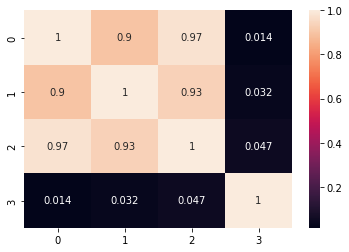

In [19]:
# from pyspark.ml.stat import Correlation
pearsonCorr = Correlation.corr(final_data, 'features', 'pearson').collect()[0][0]
array = pearsonCorr.toArray()

import seaborn as sns

sns.heatmap(array, annot=True)

Looks like the first and second features are highly correlated, along with the 4th and 5th and 4th and 6th. We may want to consider removing one of the variables in each correlation pair if we decide to use a linear regression model.

** Split dataframe into training and evaluation (test) dataframes**

In [20]:
train,test = final_data.randomSplit([0.7,0.3])

## Train

Let's train a Random Forest algorithm to start with

In [21]:
# Fit our model
regressor = LinearRegression()
fitModel = regressor.fit(train)

## Test

We will use the Root Mean Squared Error as our evaluation metric. 

In [22]:
# Specify which evaluator you want to use
evaluator = RegressionEvaluator(metricName="rmse")

In [23]:
# Make predictions.
predictions = fitModel.transform(test)
# Select (prediction, true label) and compute test error

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 81747.4


## Linear Regression (without cross validation)

**Recap from the content review lecture** <br>
Linear regression is the most basic and commonly used predictive analysis. Regression estimates are used to describe data and to explain the relationship between one dependent variable and one or more independent variables.

“Simple” linear regression means there is only one independent variable and “multiple” linear regression means there is more than one independent variables. 

Researchers often use a linear relationship to predict the (average) numerical value of Y for a given value of X using a straight line (called the regression line). If you know the slope and the y-intercept of that regression line, then you can plug in a value for X and predict the average value for Y. In other words, you predict (the average) Y from X. Of course this is just for simple linear regression. As you add more variables, your graph will look more and more complex as it becomes a three-dimensional space. But this is the basic concept. Think back to your high school algebra class :) Your goal with this analysis is to find the line that has the least amount of error which is the sum of the distance between each one of the data points and the line.

**PySpark Documention Link:** https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression

In [25]:
regressor = LinearRegression()

#first without cross val
fitModel = regressor.fit(train)

# Load the Summary
trainingSummary = fitModel.summary

# Print the coefficients and intercept for linear regression
print('\033[1m' + "Linear Regression Model Summary without cross validation:"+ '\033[0m')
print(" ")
print("Intercept: %s" % str(fitModel.intercept))
print("")
# Summarize the model over the training set and print out some metrics
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: (scaled loss + regularization) at each iteration \n %s" % str(trainingSummary.objectiveHistory))
print("")

# Print the Errors
print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Training r2: %f" % trainingSummary.r2)
print("")


# Now load the test results
test_results = fitModel.evaluate(test)

# And print them
print("Test RMSE: {}".format(test_results.rootMeanSquaredError))
print("Test r2: {}".format(test_results.r2))
print("")

Linear Regression Model Summary without cross validation:
 
Intercept: -19963.12028472163

numIterations: 1
objectiveHistory: (scaled loss + regularization) at each iteration 
 [0.0]

Training RMSE: 81339.997914
Training r2: 0.505040

Test RMSE: 81747.37843572411
Test r2: 0.4946121746363439



## Linear Regression with cross val

In [26]:
regressor = LinearRegression()

#Now train with cross val
paramGrid = (ParamGridBuilder() \
             .addGrid(regressor.maxIter, [10, 15]) \
             .addGrid(regressor.regParam, [0.1, 0.01]) \
             .build())

evaluator = RegressionEvaluator(metricName="rmse")

#Cross Validator requires all of the following parameters:
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # 3 is best practice

print('\033[1m' + "Linear Regression Model Summary WITH cross validation:"+ '\033[0m')
print(" ")
# Run cross validations
fitModel = crossval.fit(train)

# Extract Best model
LR_BestModel = fitModel.bestModel

# Get Model Summary Statistics
# ModelSummary = fitModel.bestModel.summary
ModelSummary = LR_BestModel.summary
print("Coefficient Standard Errors: ")
coeff_ste = ModelSummary.coefficientStandardErrors

print(coeff_ste)
      
print("P Values: ") 

print("PValues")

# Use test set here so we can measure the accuracy of our model on new data
ModelPredictions = fitModel.transform(test)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
test_results = evaluator.evaluate(ModelPredictions)
print('RMSE:', test_results)

Linear Regression Model Summary WITH cross validation:
 
Coefficient Standard Errors: 
[4345.956107628551, 2531.4696318714505, 5234.3272200886695, 1915.6632932002742, 7413.666167006311]
P Values: 
PValues
RMSE: 81747.38322298482


## Decision Tree Regressor

**Recap from the content review lecture** <br>
Recall that Decision Trees break down a data set into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches. Leaf node represents a classification or decision. The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data.

Decision trees are most commonly used in classification exercises, but they can also used for regression problems as well. In a standard classification tree, the idea is to split the dataset based on homogeneity of data. Let’s say for example we have two variables: age and weight that predict if a person is going to sign up for a gym membership or not. In our training data if it showed that 90% of the people who are older than 40 signed up, we split the data here and age becomes a top node in the tree. We can almost say that this split has made the data "90% pure". 

In a regression tree the idea is this: since the target variable does not have classes, we fit a regression model to the target variable using each of the independent variables. Then for each independent variable, the data is split at several split points. At each split point, the "error" between the predicted value and the actual values is squared to get a "Sum of Squared Errors (SSE)". The split point errors across the variables are compared and the variable/point yielding the lowest SSE is chosen as the root node/split point. This process is recursively continued.

The core algorithm for building decision trees called ID3 by J. R. Quinlan which employs a top-down, greedy search through the space of possible branches with no backtracking. The ID3 algorithm can be used to construct a decision tree for regression by replacing Information Gain with Standard Deviation Reduction.


**PySpark Documentation Link:** https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor

In [29]:
regressor = DecisionTreeRegressor()

# Build your parameter grid
paramGrid = (ParamGridBuilder() \
#                          .addGrid(regressor.maxDepth, [20, 30]) \
                         .addGrid(regressor.maxBins, [10, 20, 40]) \
                         .build())

#Cross Validator requires all of the following parameters:
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse"),
                          numFolds=2) # 3 is best practice

# Fit Model: Run cross-validation, and choose the best set of parameters.
fitModel = crossval.fit(train)

# Get Best Model
DT_BestModel = fitModel.bestModel

# FEATURE IMPORTANCES
# Estimate of the importance of each feature.
# Each feature’s importance is the average of its importance across all trees 
# in the ensemble The importance vector is normalized to sum to 1. 
print(" ")
print('\033[1m' + " Feature Importances"+ '\033[0m')
print("(Scores add up to 1)")
print("Lowest score is the least important")
print(" ")
DT_featureImportances = DT_BestModel.featureImportances.toArray()
# Convert from numpy array to list
imp_scores = []
for x in DT_featureImportances:
    imp_scores.append(float(x))

# Make predictions.
# PySpark will automatically use the best model when you call fitmodel
predictions = fitModel.transform(test)


# And then apply it your predictions dataframe
rmse = evaluator.evaluate(predictions)
print(rmse)

 
 Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
81939.48519048568


## Random Forest Regressor

**Recap from the content review lecture** <br>
Recal from the Classification lectures that Random Forest is an ensemble method that predicts based on the majority of votes from each of the decision trees made. The idea is still the same here (with regression), it’s just that Standard Deviation Reduction techniques are used instead of Information Gain as we touched on in the Decision Tree explanation. 

**PySpark Documentation link:** https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor

In [34]:
regressor = RandomForestRegressor()

# Add parameters of your choice here:
paramGrid = (ParamGridBuilder() \
#                            .addGrid(regressor.maxDepth, [2, 5, 10])
#                            .addGrid(regressor.maxBins, [5, 10, 20])
               .addGrid(regressor.numTrees, [5, 20,100])
             .build())

#Cross Validator requires all of the following parameters:
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # 3 is best practice
# Fit Model: Run cross-validation, and choose the best set of parameters.
fitModel = crossval.fit(train)

# Get Best Model
RF_BestModel = fitModel.bestModel

# FEATURE IMPORTANCES
# Estimate of the importance of each feature.
# Each feature’s importance is the average of its importance across all trees 
# in the ensemble The importance vector is normalized to sum to 1. 
print(" ")
print('\033[1m' + " Feature Importances"+ '\033[0m')
print("(Scores add up to 1)")
print("Lowest score is the least important")
print(" ")
RF_featureImportances = RF_BestModel.featureImportances.toArray()
# Convert from numpy array to list
imp_scores = []
for x in RF_featureImportances:
    imp_scores.append(float(x))
    
# Make predictions.
# PySpark will automatically use the best model when you call fitmodel
predictions = fitModel.transform(test)

# And then apply it your predictions dataframe
rmse = evaluator.evaluate(predictions)
print(rmse)

 
 Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
79983.96874273424


## Gradient Boosted Regressor

**Recap from the content review lecture** <br>
The same goes with gradient boosting (Standard Deviation Reduction techniques are used instead of Information Gain), but with more of a hierarchical approach. It combines the weak learners (binary splits) to strong prediction rules that allow a flexible partition of the feature space. The objective here, as is of any supervised learning algorithm, is to define a loss function and minimize it. So it basically tries a whole bunch of different ways to analyze your data and returns the best one. 

**PySpark Documentation link:** https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.GBTRegressor

In [31]:
regressor = GBTRegressor()

# Add parameters of your choice here:
paramGrid = (ParamGridBuilder() \
                           .addGrid(regressor.maxDepth, [2, 5, 10])
#                            .addGrid(regressor.maxBins, [5, 10, 20])
                           .build())

#Cross Validator requires all of the following parameters:
crossval = CrossValidator(estimator=regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # 3 is best practice
# Fit Model: Run cross-validation, and choose the best set of parameters.
fitModel = crossval.fit(train)

# Get Best Model
GBT_BestModel = fitModel.bestModel

# FEATURE IMPORTANCES
# Estimate of the importance of each feature.
# Each feature’s importance is the average of its importance across all trees 
# in the ensemble The importance vector is normalized to sum to 1. 
print(" ")
print('\033[1m' + " Feature Importances"+ '\033[0m')
print("(Scores add up to 1)")
print("Lowest score is the least important")
print(" ")
GBT_featureImportances = GBT_BestModel.featureImportances.toArray()
# Convert from numpy array to list
imp_scores = []
for x in GBT_featureImportances:
    imp_scores.append(float(x))


# Make predictions.
# PySpark will automatically use the best model when you call fitmodel
predictions = fitModel.transform(test)

# And then apply it your predictions dataframe
rmse = evaluator.evaluate(predictions)
print(rmse)

 
 Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
75383.71269056044


## Take aways

We can see from the output above that the GBTRegressor way out performed the other models judging from the RMSE (compare Training RMSE to all others). No surprise there. 

We also notice that the most of the P Values for the logistic regression model look pretty strong except for the second and third variables which we should consider removing if we go ahead with linear regression model. 

As for the tree models, it looks like population was the best feature.

Let's see how your predictions were

In [32]:
predictions = GBT_BestModel.transform(test)
predictions.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|[1.38629436111989...|275000.0|123140.26167571312|
|[1.38629436111989...|350000.0|225912.81659973995|
|[1.38629436111989...|275000.0| 336537.0849654914|
|[1.60943791243410...| 67500.0|123140.26167571312|
|[1.79175946922805...|450000.0|187365.71943254577|
|[1.79175946922805...|162500.0|123140.26167571312|
|[1.94591014905531...|212500.0| 207362.0238319318|
|[2.07944154167983...|175000.0|146394.37735979608|
|[2.07944154167983...|162500.0|225912.81659973995|
|[2.19722457733621...|450000.0|123140.26167571312|
|[2.19722457733621...|162500.0| 207362.0238319318|
|[2.30258509299404...|175000.0|123140.26167571312|
|[2.30258509299404...|262500.0| 207362.0238319318|
|[2.39789527279837...|137500.0|150454.27707502517|
|[2.39789527279837...| 55000.0|150454.27707502517|
|[2.39789527279837...| 52500.0|186267.35956793829|
|[2.48490664978800...| 75000.0|

If you want to save your model you can simply...

In [ ]:
# this path will create the folder
from datetime import datetime
timestamp = str(datetime.now()) #return local time
path = 'GBT_Model_'+timestamp
GBT_BestModel.save(path)